## Traitement des images
* Prétraitement des images 
* Extration des features avec SIFT / ResNet50 / VGG16 
* Réduction des features avec PCA & t-SNE 
* Réalisation d’un clustering via Kmeans avec K= nombre de catégories de produits, sur les features réduites par t-SNE. 
* Comparaison des catégories prédites via Kmeans par rapport aux catégories réelles à l’aide de ARI: 
  un score élevé confirmera la faisabilité du moteur de classification à partir de la description du produit.


In [1]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df0 = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")

In [3]:
df0.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [4]:
df1= df0[['product_category_tree', 'image']]

In [5]:
df1.head()

,product_category_tree,image
0,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg
2,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",64d5d4a258243731dc7bbb1eef49ad74.jpg
3,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",d4684dcdc759dd9cdf41504698d737d8.jpg
4,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",6325b6870c54cd47be6ebfbffa620ec7.jpg


In [6]:
for x, y in df1["product_category_tree"].iteritems():
    pos= y.find('>>')
    sousChaine = y[2:pos]
    df1.loc[x,"product_category"]= sousChaine

C:\Users\marat\anaconda3\envs\env_1\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\marat\anaconda3\envs\env_1\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [7]:
df1.head()

,product_category_tree,image,product_category
0,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing


In [8]:
df2= df1.drop(columns=['product_category_tree'])

In [9]:
df2.head()

,image,product_category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing


In [10]:
# on retire 5518124b75d6c6dfee4c2e4c0cfa716a.jpg , erreur suite à sift.detectAndCompute().
df3= df2.loc[df2['image']!= '5518124b75d6c6dfee4c2e4c0cfa716a.jpg']

In [11]:
len (df3)

1049

In [12]:
#df4= df3.copy() 

In [13]:
df4= df2.copy()

In [14]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df4['cat'] = le.fit_transform(df4["product_category"])
y_cat_num= list(df4['cat'] )
l_cat = list(set(df4['product_category']))
df4.head()

,image,product_category,cat
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4


### Pré-traitement des images 

##### Transformation: niveau de gris, equalization, filtrage bruit, contraste, floutage ( affichage image et histogramme associée)

#### Analyse d'une image:

In [15]:
from PIL import Image, ImageOps 

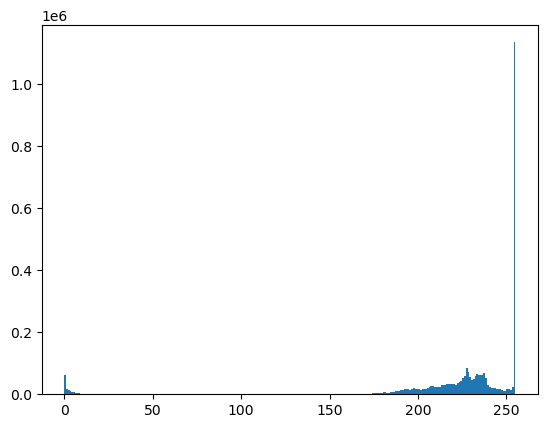

In [16]:
#charger l'image comme matrice de pixels 
img= np.array(Image.open('mug.jpg'))

#Générer et afficher l'histogramme
#Pour le normaliser: argument density= True dans plt.hist
#Pour avoir l'histogramme cumulé: argument cumulative= True
n, bins, patches = plt.hist(img.flatten(), bins= range(256))

In [17]:
type(img)

numpy.ndarray

##### Etirement de l'histogramme:

In [18]:
# creating a image1 object 
im1 = Image.open("mug.jpg")
# applying autocontrast method 
im2 = ImageOps.autocontrast(im1, cutoff = 2, ignore = 2)

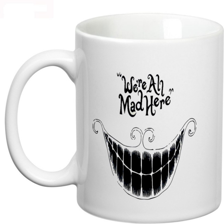

In [19]:
IMAGE_SHAPE= (224,224)
im1.resize(IMAGE_SHAPE)

In [20]:
type(im1)

PIL.JpegImagePlugin.JpegImageFile

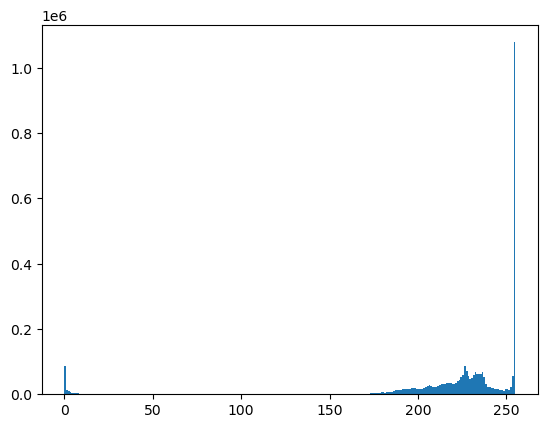

In [21]:
#Générer et afficher l'histogramme
im2_ar= np.array(im2)
n, bins, patches = plt.hist(im2_ar.flatten(), bins= range(256))

##### Egalisation de l'histogramme (ajustement du contraste)

In [22]:
# applying equalize method 
im3 = ImageOps.equalize(im2, mask = None)

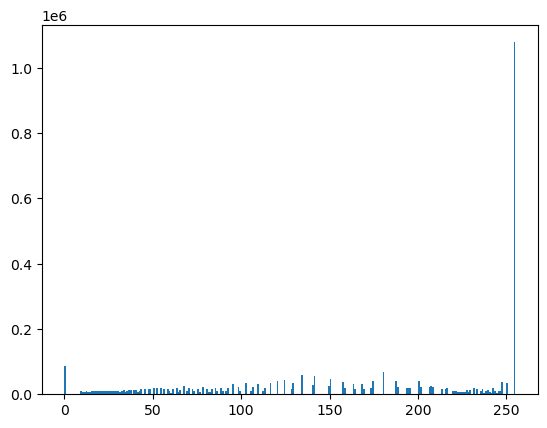

In [23]:
#Générer et afficher l'histogramme
im3_ar= np.array(im3)
n, bins, patches = plt.hist(im3_ar.flatten(), bins= range(256))

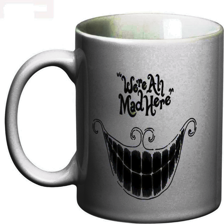

In [24]:
IMAGE_SHAPE= (224,224)
im3.resize(IMAGE_SHAPE)

In [25]:
from PIL import ImageFilter
# Appliquer le lissage par moyenne:
im3_lisse= im3.filter(ImageFilter.BoxBlur(1))

### Import du Dataset

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from os import listdir

path = "C:/Users/marat/Downloads/Py-DS-ML-Bootcamp-master/OCR/P6/Images/"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


### Descripteurs SIFT

In [27]:
import cv2

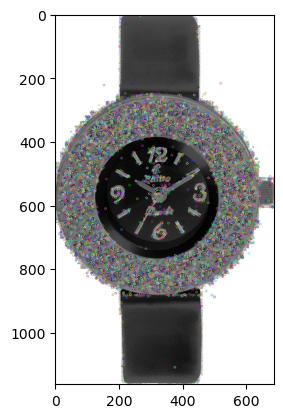

Descripteurs :  (4150, 128)

[[  3.  52. 133. ...   4.  30.  22.]
 [ 11.   1.   4. ...   0.   0.   0.]
 [  0.   0.   1. ...  14.   2.   4.]
 ...
 [ 14.   3.   5. ...   0.   0.   0.]
 [ 34.  18.   9. ...   0.   2.   3.]
 [  9. 128.  45. ...   0.   0.   0.]]


In [28]:
import cv2

sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(path+list_photos[0],0)
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

### Pré-traitement des images via SIFT

### Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

##### Nombre de descripteurs pour une image:

In [29]:
import time, cv2
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

image = cv2.imread(path+list_photos[362],0)
res = cv2.equalizeHist(image)
kp, des = sift.detectAndCompute(res, None)
sift_keypoints.append(des)
sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")


Nombre de descripteurs :  (500, 128)
temps de traitement SIFT descriptor :             0.24 secondes


In [30]:
df4.head(2)

,image,product_category,cat
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0


##### Nombre de descripteurs pour l'ensemble du dataset:

In [31]:
# identification of key points and associated descriptors
import time, cv2
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for index, row in df4.iterrows():
#for image_num in range(len(list_photos)) :
    
    if index%100 == 0 : print(index)
    image = cv2.imread(path+row['image'],0) # convert in gray
    #image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000


C:\Users\marat\anaconda3\envs\env_1\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()



Nombre de descripteurs :  (517351, 128)
temps de traitement SIFT descriptor :           547.10 secondes


### Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [32]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...


C:\Users\marat\anaconda3\envs\env_1\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  "MiniBatchKMeans is known to have a memory leak on "


temps de traitement kmeans :            10.75 secondes


### Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque cluster, le nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image, le nombre de descripteurs par cluster

In [33]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :           135.64 secondes


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [34]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 498)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [35]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df4["product_category"]
print(df_tsne.shape)

C:\Users\marat\anaconda3\envs\env_1\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images

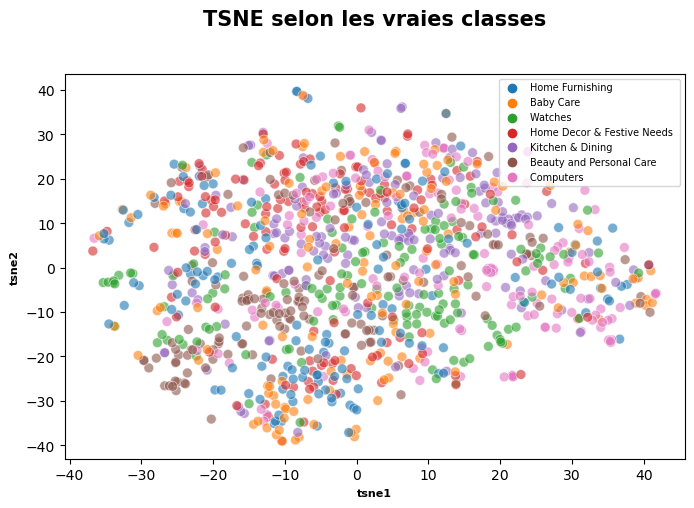

In [36]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief", s=50, alpha=0.6,
    palette=sns.color_palette('tab10', n_colors=7))

plt.title('TSNE selon les vraies classes', fontsize = 15, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 8, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 8, fontweight = 'bold')
plt.legend(prop={'size': 7}) 

plt.show()

## Analyse mesures : similarité entre catégories et clusters
###  Création de clusters à partir du T-SNE

In [37]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

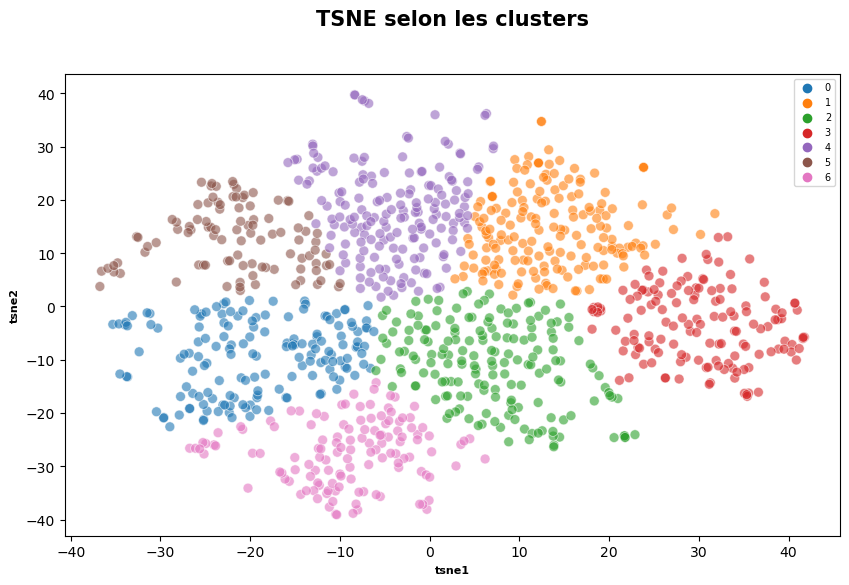

ARI :  0.05719322263506986


In [38]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7),
    s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 15, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 8, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 8, fontweight = 'bold')
plt.legend(prop={'size': 7}) 

plt.show()

labels = df4["cat"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes

In [39]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    157
1    176
2    172
3    141
4    175
5     99
6    130
Name: class, dtype: int64

In [40]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[12 23 22 20 24 18 31]
 [60 14 26 11 17  6 16]
 [12 32 22 53 23  3  5]
 [ 6 19 15  6 48 33 23]
 [21 15 17 19 13 22 43]
 [16 50 15 14 37 12  6]
 [30 23 55 18 13  5  6]]


In [41]:
print(metrics.classification_report(labels, cls.labels_))

              precision    recall  f1-score   support

           0       0.08      0.08      0.08       150
           1       0.08      0.09      0.09       150
           2       0.13      0.15      0.14       150
           3       0.04      0.04      0.04       150
           4       0.07      0.09      0.08       150
           5       0.12      0.08      0.10       150
           6       0.05      0.04      0.04       150

    accuracy                           0.08      1050
   macro avg       0.08      0.08      0.08      1050
weighted avg       0.08      0.08      0.08      1050



## CNN- Transfer learning

### ResNet50

In [42]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import manifold, decomposition
import time, cv2
from PIL import Image, ImageOps 
import h5py as h5py

In [43]:
### load model: on supprime la derniere couche via include_top= False, car on souhaite pas faire de 
# prediction dans cette partie mais uniquement extraction de features et faire la suite comme avec SIFT.
#(ARI prevu autour de 0.3)

from tensorflow.keras.applications.resnet50 import ResNet50
model_rn = ResNet50(include_top= False,weights='imagenet')
# summarize the model
model_rn.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

#### Extraction des features pour une image:

In [44]:
# import des bibiliothèques nécessaires 
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


# Read image
orig = cv2.imread(path+list_photos[362])

# Convert image to RGB from BGR (another way is to use "image = image[:, :, ::-1]" code)
#orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

# Resize image to 224x224 size
image = cv2.resize(orig, (224, 224)).reshape(-1, 224, 224, 3)

# We need to preprocess imageto fulfill ResNet50 requirements
image = tf.keras.applications.resnet50.preprocess_input(image)

# Extracting our features
features = model_rn.predict(image)

features.shape

1/1 [==============================] - 1s 1s/step


(1, 7, 7, 2048)

In [45]:
features.flatten().shape

(100352,)

In [46]:
# Extration des fetaures pour l'ensemble des images:
import time, cv2
lst_feat = []
temps1=time.time()

for index, row in df4.iterrows():
            
            if index%100 == 0 : print(index)
            
            # Reading and preprocessing image
            image = cv2.imread(path+row['image'])
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # autre methode que le reshape(): np.expand_dims(cv2.resize(image, (224, 224)), axis=0)
            image = np.expand_dims(cv2.resize(image, (224, 224)), axis=0)
            #image = cv2.resize(image, (224, 224)).reshape(1, 224, 224, 3)
            #resnet50 ald mobilenet
            image = tf.keras.applications.resnet50.preprocess_input(image)
  
            # Extracting features
            feat = model_rn.predict(image, verbose=0)
        
            
            # Store features and label in our lists
            lst_feat.append(feat.flatten())
            
  
array_feat = np.asarray(lst_feat)

print()
print("Array shape : ", array_feat.shape)

duration1=time.time()-temps1
print("temps de traitement resnet50 : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Array shape :  (1050, 100352)
temps de traitement resnet50 :           237.32 secondes


### Réduction de dimension PCA

In [47]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", array_feat.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(array_feat)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 100352)
Dimensions dataset après réduction PCA :  (1050, 975)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [48]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df4["product_category"]
print(df_tsne.shape)

C:\Users\marat\anaconda3\envs\env_1\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(1050, 3)


### Analyse visuelle : affichage T-SNE selon catégories d'images

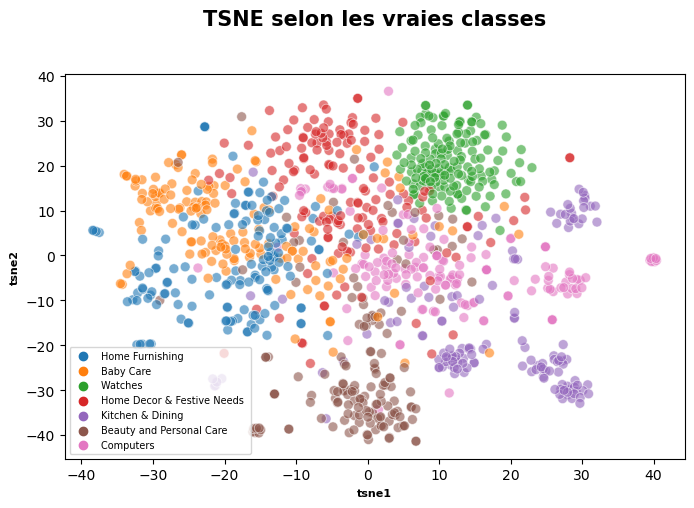

In [49]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief", s=50, alpha=0.6,
    palette=sns.color_palette('tab10', n_colors=7))

plt.title('TSNE selon les vraies classes', fontsize = 15, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 8, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 8, fontweight = 'bold')
plt.legend(prop={'size': 7}) 

plt.show()

## Analyse mesures : similarité entre catégories et clusters
###  Création de clusters à partir du T-SNE

In [50]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
#cls.fit(feat_pca)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1050, 4)


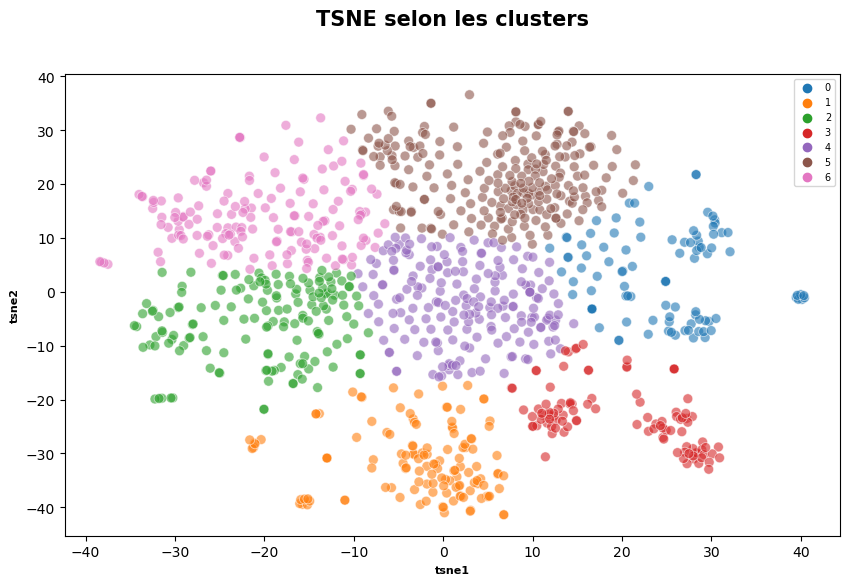

ARI :  0.3545898721543811


In [51]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7),
    s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 15, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 8, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 8, fontweight = 'bold')
plt.legend(prop={'size': 7}) 

plt.show()

labels = df4["cat"].tolist()
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### VGG16

In [52]:
# example of loading the vgg16 model
from keras.applications.vgg16 import VGG16
# load model
model_vg = VGG16(include_top=False)
# summarize the model
model_vg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

#### Extration des features pour une image:

In [53]:
# Import des bibliothèques nécessaires:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
#from keras.applications.vgg16 import preprocess_input

# Read image
orig = cv2.imread(path+list_photos[362])

# Convert image to RGB from BGR (another way is to use "image = image[:, :, ::-1]" code)
#orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

# Resize image to 224x224 size
#image = np.expand_dims(cv2.resize(image, (224, 224)), axis=0)
image = cv2.resize(orig, (224, 224)).reshape(-1, 224, 224, 3)

# We need to preprocess imageto fulfill ResNet50 requirements
image = tf.keras.applications.vgg16.preprocess_input(image)

# Extracting our features
features = model_vg.predict(image)

features.shape

1/1 [==============================] - 0s 302ms/step


(1, 7, 7, 512)

In [54]:
features.flatten().shape

(25088,)

#### Extration des features pour l'ensemble des images:

In [55]:
# Extration des fetaures pour l'ensemble des images:
import time, cv2
lst_feat = []
temps1=time.time()

for index, row in df4.iterrows():
            
            if index%100 == 0 : print(index)
            
            # Reading and preprocessing image
            image = cv2.imread(path+row['image'])
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # autre methode que le reshape(): np.expand_dims(cv2.resize(image, (224, 224)), axis=0)
            image = np.expand_dims(cv2.resize(image, (224, 224)), axis=0)
            #image = cv2.resize(image, (224, 224)).reshape(1, 224, 224, 3)
            #resnet50 ald mobilenet
            image = tf.keras.applications.vgg16.preprocess_input(image)
  
            # Extracting des features
            feat = model_vg.predict(image, verbose=0)
        
            
            # Store features and label in our lists
            lst_feat.append(feat.flatten())
            
  
array_feat = np.asarray(lst_feat)

print()
print("Array shape : ", array_feat.shape)

duration1=time.time()-temps1
print("temps de traitement resnet50 : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Array shape :  (1050, 25088)
temps de traitement resnet50 :           282.97 secondes


In [56]:
array_feat.flatten().shape

(26342400,)

### Réduction de dimension PCA

In [57]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", array_feat.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(array_feat)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 25088)
Dimensions dataset après réduction PCA :  (1050, 939)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [58]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df4["product_category"]
print(df_tsne.shape)

C:\Users\marat\anaconda3\envs\env_1\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(1050, 3)


### Analyse visuelle : affichage T-SNE selon catégories d'images

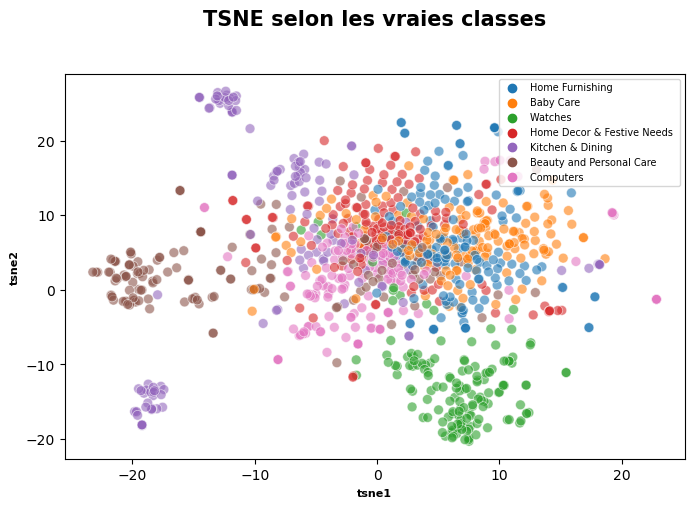

In [59]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief", s=50, alpha=0.6,
    palette=sns.color_palette('tab10', n_colors=7))

plt.title('TSNE selon les vraies classes', fontsize = 15, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 8, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 8, fontweight = 'bold')
plt.legend(prop={'size': 7}) 

plt.show()

### Analyse mesures : similarité entre catégories et clusters
####  Création de clusters à partir du T-SNE

In [60]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
#cls.fit(feat_pca)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1050, 4)


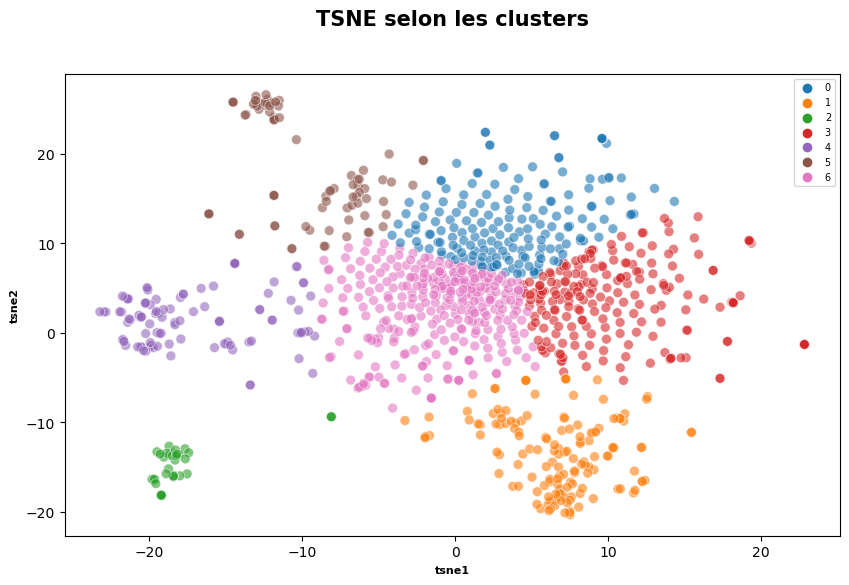

ARI :  0.31897309900066845


In [61]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7),
    s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 15, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 8, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 8, fontweight = 'bold')
plt.legend(prop={'size': 7}) 

plt.show()

labels = df4["cat"].tolist()
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))